In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
import os
import random
from yaml import safe_load
from pandas import read_csv, DataFrame, pivot_table
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error

/Users/praveenp/Documents/Projects/Project_01/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Function - Extract Series for Modelling

- **Purpose** = Read processed CSV file from "../data/processed" and convert to series (for any one location).
Additional processing of series are

    - Check the stationarity of series.

    - If not stationary (with 95% confidence) then differentiate series.

    - Even after 2 differentitation of series, if series is not stationary then STOP.

- **Input** = Dataframe, location ID (0 to 299), and variable.

    - For daily data, variables are rain, tmin, tmax

    - For monthly data, variables are rain_sum, rain_mean, rain_std, tmin_mean, tmin_std, tmax_mean, tmax_std

- **Output** = Three output from function are

    - series extract for given location and varaible.
    
    - d value for SARIMA model.

    - D value for SARIMA model.

In [3]:
# Function - Check stationarity for given values of d and D values
def check_stationarity(series, d=0, D=0, m=1):
    # Check for d value
    if d != 0:
        for id_ in range(d):
            series = np.diff(series, n=1)
    
    # Check for D value
    if D != 0:
        for id_ in range(D):
            series = np.diff(series, n=m)
    
    # Print out results for stationarity
    print('\nGiven (d, D) set = ' + str(d) + ' and ' + str(D))
    print("Stationarity P score = ", adfuller(series)[1])
    
    if adfuller(series)[1] <= 0.05: 
        return True
    else:
        return False

In [4]:
# Function - Extract series of given location and variable from CSV file
def extract_series(df, pos, var, dChoices, m=1):
    global configDatabase
    
    # Extract Relevant Data
    series = df[df.pos == pos][var]
    series.reset_index(inplace=True, drop=True)
    
    # Dickey-Fuller test for stationarity
    # P value must be less than 0.05 (for serier to be stationalry)
    flag = check_stationarity(series)
    
    # Estimate value of d and D for SARIMA
    if flag:
        d = D = 0
    else:
        for dval in dChoices:
            d, D = dval
            flag = check_stationarity(series, d, D, m)
            if flag:
                break
    if not flag:
        "ERROR: Given (d, D) sets are not viable."

    return series, d, D

### Function - Extract Averaged Series

- **Purpose** = Extract series which is averaged across all locations in india

- **Inputs** = Dataframe; Variable to be consider; Index used for averaging

    - For daily data, variables are rain, tmin, tmax

    - For monthly data, variables are rain_sum, rain_mean, rain_std, tmin_mean, tmin_std, tmax_mean, tmax_std

- **Output** = Three output from function are

    - series extract for given location and varaible.
    
    - d value for SARIMA model.

    - D value for SARIMA model.

In [5]:
# Function - Extract Averaged Series
def extract_avg_series(df, var, index, dChoices, m=1):
    global configDatabase
    
    # Pivot table to get averaged value
    table = pivot_table(df, values=var, index=index, aggfunc="mean")
    table.reset_index(inplace=True)
    series = table[var]
    series.reset_index(inplace=True, drop=True)
    
    # Dickey-Fuller test for stationarity
    # P value must be less than 0.05 (for serier to be stationalry)
    flag = check_stationarity(series)
    
    # Estimate value of d and D for SARIMA
    if flag:
        d = D = 0
    else:
        for dval in dChoices:
            d, D = dval
            flag = check_stationarity(series, d, D, m)
            if flag:
                break
    if not flag:
        "ERROR: Given (d, D) sets are not viable."

    return series, d, D
    

### Function - SARIMA Model Estimation

- **Purpose** = Get best fit SARIMA model for given series. 

- **Input** = Various inputs are

    - Series used for SARIMA modeling.

    - d, D, and m value for SARIMA modeling.

    - *show_stats* - If "True" then show the model summary; plot validation and prediction.

- **Output** = Optimal parameters for SARIMA model. Also get MSE for training and testing.

In [6]:
# Function - SARIMA Model Estimation
def model_sarima(series, d, D, m, show_stats=False):
    # Convert series into training and validation set
    endID = len(series)
    cutID = int(0.7*endID)
    trainSeries = series[:cutID]
    validateSeries = series[cutID:]
    
    # SMARIMA parameter estimation
    SARIMA_model = auto_arima(trainSeries, 
                              start_p=0, start_q=0, max_p=5, max_q=5, d=d, 
                              start_P=0, start_Q=0, max_P=5, max_Q=5, D=D, m=m, 
                              test='adf', seasonal=True, trace=False, 
                              error_action='ignore', suppress_warnings=True, stepwise=True)
    param = (SARIMA_model.get_params()['order'], SARIMA_model.get_params()['seasonal_order'])
    if show_stats:
        print(SARIMA_model.summary())
    
    # Build SARIMA Model
    SARIMA_model = SARIMAX(trainSeries, order=param[0], seasonal_order=param[1], simple_differencing=False)
    SARIMA_model_fit = SARIMA_model.fit(disp=False)
    trainMSE = np.round(SARIMA_model_fit.mse,3)
    
    # Validate 
    SARIMA_pred = SARIMA_model_fit.get_prediction(cutID+1, endID).predicted_mean
    validateMSE = np.round(mean_squared_error(validateSeries, SARIMA_pred),3)
    if show_stats:
        fig, ax = plt.subplots()
        ax.plot(validateSeries, 'b-', label='actual')
        ax.plot(SARIMA_pred, 'g-', label='SARIMA pred')
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.legend()
        ax.set_xlim(cutID-10, endID+10)
        plt.tight_layout()
    
    return SARIMA_model_fit, param, trainMSE, validateMSE

### Function - Single Location Modelling

- **Purpose** = SARIMA modelling for single location.

- **Input** = Dataframe and variable.

- **Output** = Optimal parameter for SARIMA, MSE for training, and MSE for Validation.

In [7]:
# Function - SARIMA modelling for single location
def model_single_loc(df, var, m):
    global configDatabase
    
    # Local Varaibles
    random.seed(configDatabase['seed'])
    pos = df.pos.unique()[random.randint(0, configDatabase['posCount'])]
    #pos = df.pos.unique()[149]
    
    # Extract series from dataframe 
    rainMean, d, D = extract_series(df, pos=pos, var=var, dChoices=configDatabase['SAMIRA']['dChoices'], m=m)
    
    # Get optimal parameter for SARIMA
    model, param, mse01, mse02 = model_sarima(rainMean, d, D, m, show_stats=True)
    print("\nSARIMA optimal parameter = ", param)
    print("Training MSE = " + str(mse01) + " and Validation MSE = " + str(mse02))
    return model

### Function - Multiple Location Modelling

- **Purpose** = SARIMA modelling for multiple location.

- **Input** = 

- **Output** = CSV file containing

    - *pos* = Tuple of Latitude and Longitude.
    
    - *param* = Optimal parameters for SARIMA model.
    
    - *tainMSE* = MSE for Training.
    
    - *valMSE* = MSE for Validation.

In [8]:
# Function - SARIMA modelling for multiple location
def model_multiple_loc(df, var, m, fileName):
    global configDatabase
    
    # Initiaze Empty Database
    dfMonthly = DataFrame(columns=['pos', 'param', 'trainMSE', 'valMSE'])
    
    for posVal in df.pos.unique():
        # Extract series from dataframe
        rainMean, d, D = extract_series(df, pos=posVal, var=var, dChoices=configDatabase['SAMIRA']['dChoices'], m=m)
        
        # Get optimal parameter for SARIMA
        model, param, mse01, mse02 = model_sarima(rainMean, d, D, m, show_stats=False)
        dfMonthly.loc[len(dfMonthly.index)] = [posVal, param, mse01, mse02]
        
        # Save dataframe for optimal parameters dor each location
        dfMonthly.to_csv(fileName, index=False)

### Function - Averaged across Location Modelling

- **Purpose** = SARIMA modelling for average data across location.

- **Input** = Dataframe ; variable for modelling ; index for averaging.

- **Output** = Optimal parameter for SARIMA, MSE for training, and MSE for Validation.

In [9]:
# Function - 
def model_avg_loc(df, var, index, m):
    global configDatabase
    
    # Extract series from dataframe 
    rainMean, d, D = extract_avg_series(df, var, index, dChoices=configDatabase['SAMIRA']['dChoices'], m=m)
    
    # Get optimal parameter for SARIMA
    model, param, mse01, mse02 = model_sarima(rainMean, d, D, m, show_stats=True)
    print("\nSARIMA optimal parameter = ", param)
    print("Training MSE = " + str(mse01) + " and Validation MSE = " + str(mse02))
    return model
    

## Main Code


Given (d, D) set = 0 and 0
Stationarity P score =  0.007786625112684367
                                   SARIMAX Results                                   
Dep. Variable:                             y   No. Observations:                  168
Model:             SARIMAX(1, 0, [1, 2], 12)   Log Likelihood                -228.160
Date:                       Thu, 21 Nov 2024   AIC                            466.321
Time:                               21:49:58   BIC                            481.941
Sample:                                    0   HQIC                           472.660
                                       - 168                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0054      0.008      0.722      0.470      -0.009       0.020
ar

/Users/praveenp/Documents/Projects/Project_01/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/praveenp/Documents/Projects/Project_01/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'



SARIMA optimal parameter =  ((0, 0, 0), (1, 0, 2, 12))
Training MSE = 1.808 and Validation MSE = 4.555


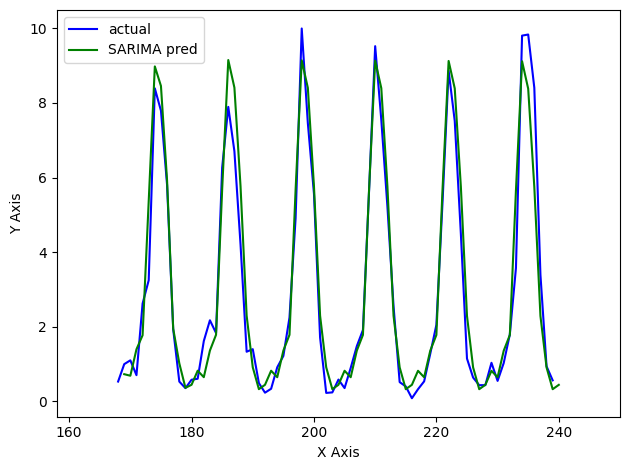

In [ ]:
# Main Code
# Options for runType -> 1 = One Location ; 2 = Multiple Location ; 3 = Averaged Across Locations
runType = 3
# Options for dataType -> 1 = Daily ; 2 -> Monthly
dataType = 2
configDatabase = safe_load(open("../config.yaml"))
m = 12

if dataType == 1:
    var = 'rain'
    index = 'day'
    df = read_csv(os.path.join(configDatabase['dir']['dataProcess'], configDatabase['file']['train01']), compression='gzip')
    fileName = os.path.join(configDatabase['dir']['model'], configDatabase['file']['sarima01'])
    fileName = fileName.replace('.csv', '_final.csv')
else:
    var = 'rain_mean'
    index = 'monthID'
    df = read_csv(os.path.join(configDatabase['dir']['dataProcess'], configDatabase['file']['train02']), compression='gzip')
    fileName = os.path.join(configDatabase['dir']['model'], configDatabase['file']['sarima02'])
    fileName = fileName.replace('.csv', '_final.csv')

if runType == 1:
    model = model_single_loc(df, var, m)
    model.save(os.path.join(configDatabase['dir']['model'], configDatabase['SAMIRA']['modelMonthlySingle']))
elif runType == 2:
    model_multiple_loc(df, var, m, fileName)
else:
    model = model_avg_loc(df, var, index, m)
    model.save(os.path.join(configDatabase['dir']['model'], configDatabase['SAMIRA']['modelMonthlyAvg']))
